#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96 #  (submerged) [kg/m]

In [5]:
node_N = 17

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # 32219000   # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.77206435,  0.57363326, -0.27360835],
       [ 0.16873225,  0.23005092,  0.95843936],
       [ 0.61273654, -0.78614341,  0.08082368]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.012715


In [29]:
Ret.shape

(17, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000394


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[ 22660.97860912,   8095.5433307 ,  -9768.33475437],
       [ -8142.24943587,  11953.95198103,   7411.97161214],
       [  7379.51327048,  -9664.31489077,    132.43375791],
       [-18250.22304392, -11587.17863797, -12701.111012  ],
       [  1313.23879891,  -2328.70638254,    331.08871341],
       [ -7067.27566083,   4180.30730928,  -1362.90981906],
       [   884.70114208,   4928.37315544,   2547.37217575],
       [  9595.68207104,  11892.43515468,  -9011.61144625],
       [  -412.85892657, -10582.6508863 ,   3784.39247139],
       [-10690.83906493, -18043.09052303,  -2167.9129056 ],
       [ -6160.9418703 ,  -1938.39024849,   4175.37831347],
       [  6529.48111294,  -2286.32229489,   5744.02419919],
       [ 13768.71026445,  13002.33961769,   2769.5532593 ],
       [ 21249.52360544,  14340.65056329, -15890.76941047],
       [ -5872.63414463,  27662.15241543,  18413.92678758],
       [ -4537.03882558,   1518.92146908,   1688.94677299],
       [ 13005.63090127,   5503.4448362 

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000453


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000524


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000216


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[ 100.94225486,   -5.71219023,  -46.96104784],
       [ -47.90707469,  -29.98573825,   18.12342059],
       [ -54.91653689,    6.20181902, -107.38270149],
       [  39.72341851,  -73.04451146,  -37.83460099],
       [  94.66616151,  -42.3562817 ,   60.97235642],
       [ -35.03509917,    6.62464885,  -59.54462952],
       [  31.84332378,  -69.93989926,  -25.0179445 ],
       [ -94.54221104,  -50.70924341,   14.88393614],
       [ 150.40633091, -161.91839302,  122.00189194],
       [  84.74863447,   56.92187219,   94.84414065],
       [ 136.33878157,  -76.20732931,  133.61353784],
       [  -2.82959184,  -75.778627  ,  -91.31749329],
       [ 121.27871214,  -37.50872446,  -68.54771825],
       [  -4.73409312,   70.92337396,  -22.37645307],
       [ -93.84284063,    8.48134791,    0.80916393],
       [ 111.27385452,  120.97983671,   46.18741722],
       [ -39.38403228,  -43.3083381 ,   36.53584407]])

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000523


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000705


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.002162


In [57]:
ωe(φ,θ,ψ,None,None)

array([[-1.41524606, -0.91387978, -0.45841059],
       [ 0.57964124,  0.22496464, -0.0389545 ],
       [ 0.08705928,  1.72884721,  1.04396676],
       [-0.89844378, -0.83470223, -0.90935581],
       [ 0.54426754,  0.92590519,  1.71822117],
       [-0.10484323,  1.49028307,  1.09506831],
       [-0.51794564,  0.66998938, -1.07275135],
       [-2.79619453,  2.66448791,  0.97594601],
       [-1.10833655, -0.26865896, -0.22042079],
       [ 0.68603848, -0.64876987, -0.46095509],
       [ 0.22290359,  1.01821599,  0.85188116],
       [ 0.42167883, -2.04999016, -0.2654745 ],
       [-0.25644913, -2.31332338,  1.21069408],
       [-1.48127821, -0.65962334,  1.14056044],
       [ 0.2190018 ,  0.79209379,  1.37256219],
       [ 0.40232066, -0.78977403,  0.35005001],
       [ 0.70981879, -0.67227927,  0.6235039 ]])

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  40.29822402,    2.90904933, -192.12277074,  -34.84282236,
         129.23207904,  -95.99279437,  -91.78987406,   89.14755168,
         -68.46708108,  -35.29359344,  200.96703049,  167.08266258,
         203.98463767,  -66.13235952,  -11.00024394,  -78.82661383,
           2.44062791],
       [-112.73443597,   -8.63888602,  -47.98238076,  -70.11498487,
         129.47212739,  -44.60867782,  -47.11790444,  -50.64971606,
         102.0664757 , -104.13204291,   86.3614954 ,   39.25783623,
         129.25241107,  -38.54527221, -128.9823456 ,   20.36926259,
         -50.48992586],
       [ 100.33323896,   -6.60357334,   95.48222976,   98.78361168,
        -110.7050386 ,   51.51766528,   14.89037443,  393.69949505,
         219.86808325,   94.03295409, -155.80920843,  -37.75487705,
         290.17595356, -108.17996135,   76.18976336,  136.55388983,
         -57.21814105]])

In [60]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001624


In [61]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [62]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [63]:
ne_(dx,dy,dz,DT,Ret)

array([[-22660.97860912,   8142.24943587,  -7379.51327048,
         18250.22304392,  -1313.23879891,   7067.27566083,
          -884.70114208,  -9595.68207104,    412.85892657,
         10690.83906493,   6160.9418703 ,  -6529.48111294,
        -13768.71026445, -21249.52360544,   5872.63414463,
          4537.03882558, -13005.63090127],
       [ -8095.5433307 , -11953.95198103,   9664.31489077,
         11587.17863797,   2328.70638254,  -4180.30730928,
         -4928.37315544, -11892.43515468,  10582.6508863 ,
         18043.09052303,   1938.39024849,   2286.32229489,
        -13002.33961769, -14340.65056329, -27662.15241543,
         -1518.92146908,  -5503.4448362 ],
       [  9640.17021214,  -7540.13615437,   -260.59830014,
         12572.94646977,   -459.25325564,   1234.74527683,
         -2675.53671798,   8883.44690402,  -3912.55701362,
          2039.74836337,  -4303.5428557 ,  -5872.18874142,
         -2897.71780153,  15762.60486824, -18542.09132981,
         -1817.11131522,  -51

In [64]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.003798


In [65]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 2.35608848e+10, -5.97522224e+09,  6.51420941e+08],
       [ 1.73234928e+09, -5.80770297e+09, -4.15923408e+09],
       [-2.25990877e+07, -2.07047269e+10,  2.98176443e+06],
       [-3.43393763e+07, -1.88738286e+10,  2.03824270e+09],
       [ 7.71509320e+09,  3.05660083e+09, -8.36064223e+10],
       [-1.12193996e+09, -1.01200169e+10,  1.25026289e+08],
       [-9.19550693e+09, -8.08255566e+09,  1.10243367e+10],
       [ 1.40847357e+10, -4.50057694e+10,  5.99305308e+10],
       [-8.56688199e+09,  4.98381876e+08,  7.30996168e+10],
       [-8.36906300e+09, -3.58547231e+10,  4.59719802e+10],
       [ 5.03274011e+10,  5.35082812e+10, -7.81217976e+10],
       [ 1.78666986e+10,  3.84515293e+10, -3.93069360e+09],
       [ 1.46012517e+08,  1.13421282e+11,  6.11848027e+07],
       [-2.56268151e+09, -5.57979844e+09, -4.56117089e+10],
       [-2.16958999e+08, -8.09798189e+09,  6.05591526e+10],
       [-3.65880042e+10,  1.45448319e+10,  4.67686283e+10],
       [ 3.58160171e+08, -2.38070016e+09

In [66]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000730


In [67]:
Re_b(Ret).shape

(17, 3, 3)

In [68]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [69]:
Irho_e(Ret).shape

(17, 3, 3)

In [70]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000278


In [71]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [72]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [73]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [74]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004894


In [75]:
d_me_

array([[-6.02440889e+02, -1.53059235e+02,  5.80464424e+01],
       [-2.05119485e+01,  6.13711190e+01,  1.28246175e+02],
       [-5.37596086e-01, -8.42332861e+01,  2.16899428e-02],
       [-1.33480790e+00, -7.14411195e+02,  7.80393059e+01],
       [ 3.72392007e+02, -3.73825532e+01, -8.56440765e+02],
       [ 1.18675617e+02,  1.04862942e+02,  8.57143608e-01],
       [-7.00638206e+02, -2.98107415e+02,  1.68768913e+03],
       [ 9.51291047e+02, -2.97365002e+03,  4.00529259e+03],
       [-9.15934164e+00, -1.57750606e+00,  2.55521914e+02],
       [ 6.06106724e+01, -3.94858597e+02,  9.75240817e+02],
       [-8.19430306e+02,  1.69132492e+02,  2.66808177e+02],
       [-2.85989191e+01,  4.15630895e+02, -3.75696196e+02],
       [-1.02068568e+01, -9.90124499e+00, -6.43416191e-01],
       [ 6.74942387e+01, -6.08405851e+02, -9.87951368e+01],
       [-8.68386132e+01,  7.05028946e+01,  4.64576835e+01],
       [-3.31912209e+02, -8.32917007e+01,  1.92723468e+02],
       [-6.33872108e+02, -1.16058270e+02

In [76]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[-22660.97860912,   8142.24943587,  -7379.51327048,
         18250.22304392,  -1313.23879891,   7067.27566083,
          -884.70114208,  -9595.68207104,    412.85892657,
         10690.83906493,   6160.9418703 ,  -6529.48111294,
        -13768.71026445, -21249.52360544,   5872.63414463,
          4537.03882558, -13005.63090127],
       [ -8095.5433307 , -11953.95198103,   9664.31489077,
         11587.17863797,   2328.70638254,  -4180.30730928,
         -4928.37315544, -11892.43515468,  10582.6508863 ,
         18043.09052303,   1938.39024849,   2286.32229489,
        -13002.33961769, -14340.65056329, -27662.15241543,
         -1518.92146908,  -5503.4448362 ],
       [  9640.17021214,  -7540.13615437,   -260.59830014,
         12572.94646977,   -459.25325564,   1234.74527683,
         -2675.53671798,   8883.44690402,  -3912.55701362,
          2039.74836337,  -4303.5428557 ,  -5872.18874142,
         -2897.71780153,  15762.60486824, -18542.09132981,
         -1817.11131522,  -51

### Vessel

In [78]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [79]:
V=VesselSemisub()

In [80]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [81]:
tau_force = V.tau(η,dη, ddη)

In [82]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [83]:
wave_coef=1

In [84]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [85]:
Hs = 2.5 # significant wave height in m

In [86]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [87]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [88]:

def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    ans=np.concatenate( [F,[0,0,0]], axis=0)
    return ans

In [89]:
tau(η, dη, wave_coef, kp, kd,3)

array([9750.        ,    0.        , 7283.67179881,    0.        ,
          0.        ,    0.        ])

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  690.7928027788513,
  1381.5856055577026,
  2072.378408336554,
  2763.171211115405,
  3453.9640138942564,
  4144.756816673108,
  4835.549619451959,
  5526.34242223081,
  6217.135225009662,
  6907.928027788513,
  7598.720830567364,
  8289.513633346216,
  8980.306436125067,
  9671.099238903918,
  10361.89204168277,
  11052.68484446162],
 [0.0,
  2.7090423503877923,
  10.836336053152266,
  24.38238107340301,
  43.34801072052057,
  67.73439169935548,
  97.54302418207908,
  132.77574190039255,
  173.43471225842703,
  219.52243646594314,
  271.0417496923585,
  327.995821240977,
  390.38815474416316,
  458.2225883786597,
  531.5032951018503,
  610.23478290842,
  694.4218951076863])

In [99]:
length_p

[690.7981147061109,
 690.8406106143384,
 690.9256050449656,
 691.0531032264977,
 691.223113002094,
 691.4356448300532,
 691.6907117844501,
 691.9883295559516,
 692.3285164527667,
 692.7112934017911,
 693.1366839498729,
 693.6047142652902,
 694.1154131393234,
 694.6688119880661,
 695.2649448543317,
 695.9038484097589]

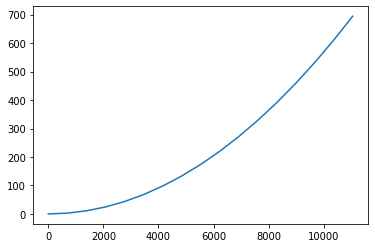

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])


    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
############################################################    

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
    return ans 

In [104]:
q0

array([0.00000000e+00, 6.90792803e+02, 1.38158561e+03, 2.07237841e+03,
       2.76317121e+03, 3.45396401e+03, 4.14475682e+03, 4.83554962e+03,
       5.52634242e+03, 6.21713523e+03, 6.90792803e+03, 7.59872083e+03,
       8.28951363e+03, 8.98030644e+03, 9.67109924e+03, 1.03618920e+04,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([0.00000000e+00, 6.90792803e+02, 1.38158561e+03, 2.07237841e+03,
       2.76317121e+03, 3.45396401e+03, 4.14475682e+03, 4.83554962e+03,
       5.52634242e+03, 6.21713523e+03, 6.90792803e+03, 7.59872083e+03,
       8.28951363e+03, 8.98030644e+03, 9.67109924e+03, 1.03618920e+04,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 690.7928027788513,
 1381.5856055577026,
 2072.378408336554,
 2763.171211115405,
 3453.9640138942564,
 4144.756816673108,
 4835.549619451959,
 5526.34242223081,
 6217.135225009662,
 6907.928027788513,
 7598.720830567364,
 8289.513633346216,
 8980.306436125067,
 9671.099238903918,
 10361.89204168277,
 11052.68484446162]

In [109]:
x0_

array([    0.        ,   690.79280278,  1381.58560556,  2072.37840834,
        2763.17121112,  3453.96401389,  4144.75681667,  4835.54961945,
        5526.34242223,  6217.13522501,  6907.92802779,  7598.72083057,
        8289.51363335,  8980.30643613,  9671.0992389 , 10361.89204168,
       11052.68484446])

In [110]:
z0

[0.0,
 2.7090423503877923,
 10.836336053152266,
 24.38238107340301,
 43.34801072052057,
 67.73439169935548,
 97.54302418207908,
 132.77574190039255,
 173.43471225842703,
 219.52243646594314,
 271.0417496923585,
 327.995821240977,
 390.38815474416316,
 458.2225883786597,
 531.5032951018503,
 610.23478290842,
 694.4218951076863]

In [111]:
z0_

array([  0.        ,   2.70904235,  10.83633605,  24.38238107,
        43.34801072,  67.7343917 ,  97.54302418, 132.7757419 ,
       173.43471226, 219.52243647, 271.04174969, 327.99582124,
       390.38815474, 458.22258838, 531.5032951 , 610.23478291,
       694.42189511])

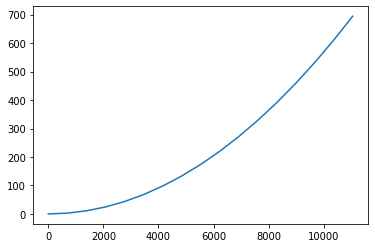

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [114]:
q0

array([0.00000000e+00, 6.90792803e+02, 1.38158561e+03, 2.07237841e+03,
       2.76317121e+03, 3.45396401e+03, 4.14475682e+03, 4.83554962e+03,
       5.52634242e+03, 6.21713523e+03, 6.90792803e+03, 7.59872083e+03,
       8.28951363e+03, 8.98030644e+03, 9.67109924e+03, 1.03618920e+04,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Dynamics

In [115]:
def grayscott1d(t, Q):
    
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 5 sec
    if t<5:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]

    tau_force = V.tau(η,dη,ddη).astype(np.float32) # /1e3


    Z0=np.dot(Re_b(Ret),tau_force[:3].reshape(3,1))

    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0.squeeze())

############################################################    
    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass],RRRR),Z).T
############################################################    

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 

    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    
    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [116]:
tspan = (0., 40)

In [117]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
print(datetime.now() - startTime1)

0:04:17.706711


### Results

In [118]:
fin=us

In [119]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14072
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.54511548e-05, 6.09962703e-04, ...,
       3.99846149e+01, 3.99940414e+01, 4.00000000e+01])
 t_events: None
        y: array([[ 0.00000000e+00,  1.12325614e-23,  1.00535518e-21, ...,
         4.21768096e+02,  4.22048658e+02,  4.22226007e+02],
       [ 6.90792803e+02,  6.90792803e+02,  6.90792803e+02, ...,
         1.11256072e+03,  1.11284129e+03,  1.11301863e+03],
       [ 1.38158561e+03,  1.38158561e+03,  1.38158561e+03, ...,
         1.80339631e+03,  1.80367724e+03,  1.80385380e+03],
       ...,
       [ 0.00000000e+00,  1.96157277e-25,  2.15499342e-24, ...,
        -4.68781649e-05, -4.54991819e-05, -4.54932645e-05],
       [ 0.00000000e+00,  1.96157277e-25,  2.15499342e-24, ...,
         3.11058442e-05,  3.11623030e-05,  3.30600865e-05],
       [ 0.00000000e+00,  1.96157277e-25,  2

In [120]:
t=fin.t

In [121]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


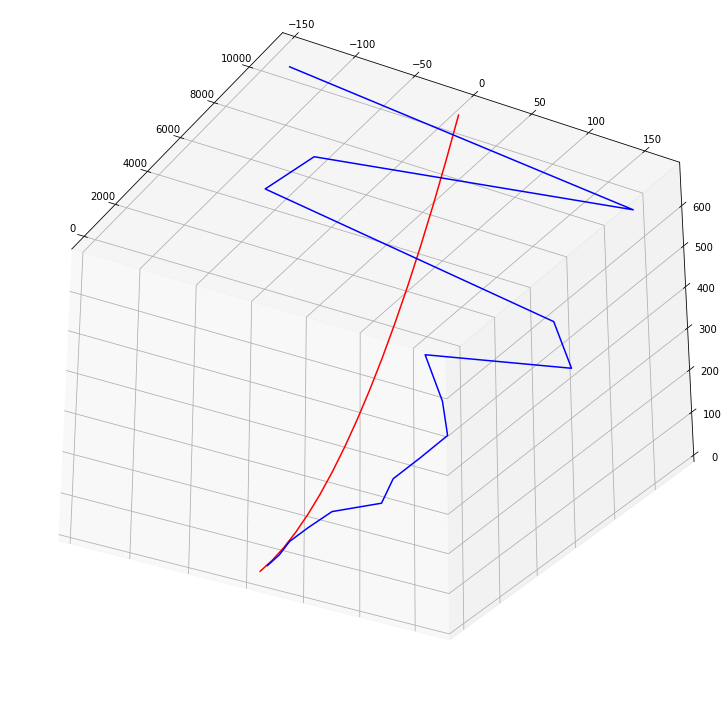

In [122]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [123]:
X,Y,Z

(array([  422.22600733,  1113.01863487,  1803.85380213,  2494.60372163,
         3185.31861003,  3875.82679863,  4566.13088779,  5255.94203899,
         5945.27434109,  6637.26960314,  7314.66431469,  7940.3311065 ,
         8668.15069284,  9189.80084791,  9996.6548484 , 10657.22057192,
        10790.79346085]),
 array([ 7.54942911e-04,  1.12031970e-01, -1.26870686e+00,  4.31144627e+00,
         1.42721490e+01,  4.63711073e+01,  4.56396421e+01,  5.82119279e+01,
         7.11199598e+01,  5.56544192e+01,  3.00205387e+01,  1.48103748e+02,
         1.20504119e+02, -1.33346039e+02, -1.05320977e+02,  1.59624849e+02,
        -1.38002312e+02]),
 array([-4.45220106e-01,  2.26388782e+00,  1.04006244e+01,  2.39313843e+01,
         4.58390758e+01,  6.58597594e+01,  9.96778422e+01,  1.35018382e+02,
         1.73983952e+02,  2.18944946e+02,  2.85337632e+02,  3.24581189e+02,
         3.88549457e+02,  4.70791377e+02,  5.40031128e+02,  6.20069327e+02,
         6.94549655e+02]))

In [124]:
X0,Y0,Z0

(array([    0.        ,   690.79280278,  1381.58560556,  2072.37840834,
         2763.17121112,  3453.96401389,  4144.75681667,  4835.54961945,
         5526.34242223,  6217.13522501,  6907.92802779,  7598.72083057,
         8289.51363335,  8980.30643613,  9671.0992389 , 10361.89204168,
        11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   2.70904235,  10.83633605,  24.38238107,
         43.34801072,  67.7343917 ,  97.54302418, 132.7757419 ,
        173.43471226, 219.52243647, 271.04174969, 327.99582124,
        390.38815474, 458.22258838, 531.5032951 , 610.23478291,
        694.42189511]))

In [125]:
us=fin.T

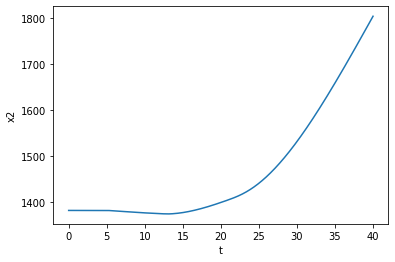

In [126]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

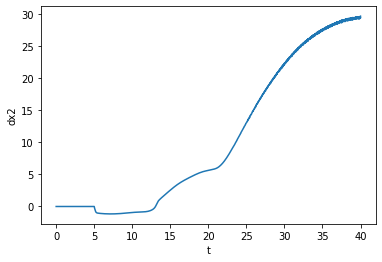

In [127]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

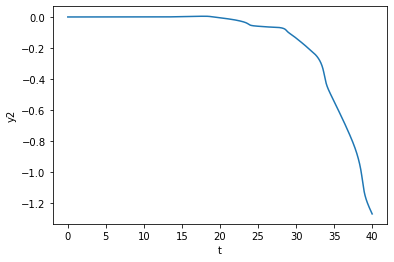

In [128]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

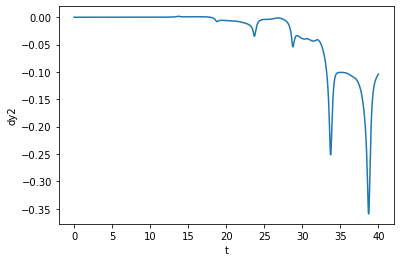

In [129]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

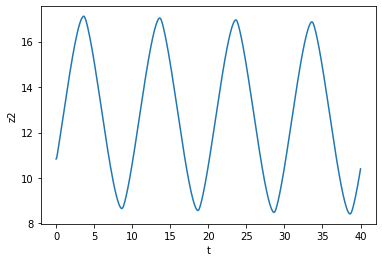

In [130]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

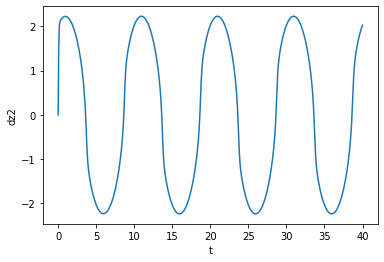

In [131]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

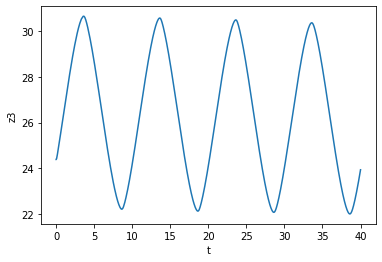

In [132]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

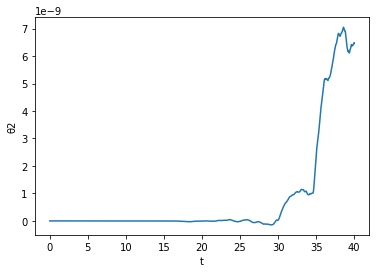

In [133]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

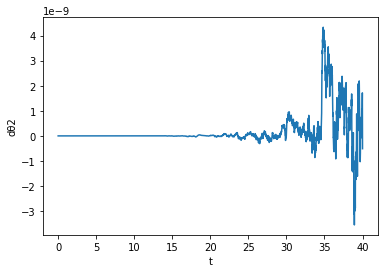

In [134]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

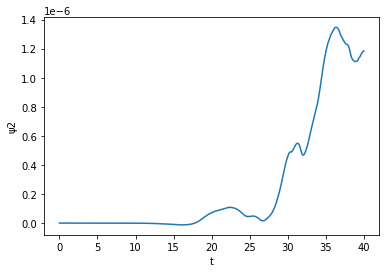

In [135]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

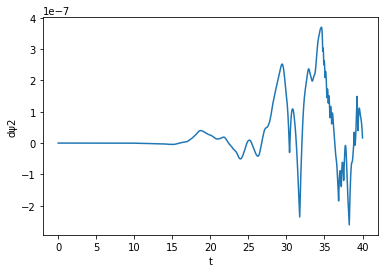

In [136]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()